# 一、读取文本

In [58]:
import pandas as pd

fake_text = pd.read_csv('DataSet_Misinfo_FAKE.csv')
real_text = pd.read_csv('DataSet_Misinfo_TRUE.csv')

fake_text.drop(fake_text.columns[0],axis=1,inplace=True)
real_text.drop(real_text.columns[0],axis=1,inplace=True)

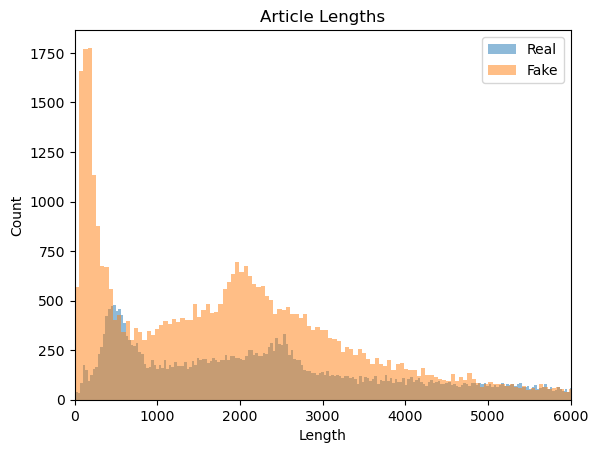

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
real_lengths = real_text['text'].apply(str).apply(len)
fake_lengths = fake_text['text'].apply(str).apply(len)

plt.hist(real_lengths, bins=2800, alpha=0.5, label='Real')
plt.hist(fake_lengths, bins=2800, alpha=0.5, label='Fake')
plt.xlim((0,6000))
plt.title('Article Lengths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.legend()
plt.show()

# 二、采用NLTK对词汇进行预处理，得到text_clean

In [11]:
# 对文本进行预处理

import string #用于去除标点符号和数字
from nltk.tokenize import word_tokenize #用于将文本token化
from nltk.corpus import stopwords #用于去除停顿词
from nltk.stem import WordNetLemmatizer #用于词形还原
from nltk import pos_tag #用于在词形还原中引入单词词性（动词、名词等提高准确率）

##定义词性识别函数用于词形还原

##直接用pos_tag函数分类过于复杂（几十类，包括比较级、最高级等），参考惯常做法降低其维数

from nltk.corpus import wordnet

#这个函数用于降低词性类别的维数以符合Lemmatizer函数的要求(参考网络资料设计）

def get_tag(tag):
    if tag[1].startswith('V'):
        return wordnet.VERB
    elif tag[1].startswith('N'):
        return wordnet.NOUN
    elif tag[1].startswith('J'):
        return wordnet.ADJ
    elif tag[1].startswith('R'):
        return wordnet.ADV
    else:
        return None


##定义文本预处理函数

stopwords_list = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def TextPreprocess(text):
    
    #删除标点符号和数字
    del_list = str.maketrans("","",string.punctuation+string.digits)
    text = str(text).translate(del_list)
    
    #小写
    text = text.lower()
    
    #token化以便进行后续筛选
    words_tokenized = word_tokenize(text)
    
    #去除停顿词
    words_dropped = [word for word in words_tokenized if word not in stopwords_list]
    
    #词形还原-需要用到词性pos_tag、get_tag（上面定义的函数）
    words_clean = []
    for word in words_dropped:
        wordpos = get_tag(pos_tag([word])[0]) or wordnet.NOUN
        words_clean.append(lemmatizer.lemmatize(word,pos=wordpos))
    
    #现在得到的是散装的wordlist，后续编码需要string格式，故还需要转换回去
    text_clean = " ".join(words_clean)
    
    return text_clean
    

In [12]:
#现在对两个文本进行预处理

real_text['text'] = real_text['text'].apply(TextPreprocess)
fake_text['text'] = fake_text['text'].apply(TextPreprocess)


In [13]:
import numpy as np

#合并数据集
mixed_text = pd.concat([real_text,fake_text])

#生成标签栏
Y = np.concatenate([np.ones(len(real_text)), np.zeros(len(fake_text))])

# 三、对文本进行向量化提取并用传统分类模型进行分类

接下来对文本进行向量化特征提取并通过回归方法进行分类，本研究尝试的方法有：

（1）逻辑回归 （2）KNN （3）SVM （4）随机森林

由于特征提取的结果有一定的不确定性，我们采取多次操作取平均值的方法评估各方法的准确率（此处为5次）

## （1）CountVectorizer方法编码

In [7]:
#对KNN进行调参

from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

#对提取的文本进行向量化
vectorize = CountVectorizer()
X = vectorize.fit_transform(mixed_text['text'])
    
#分割测试集与训练集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

knntest = []
for i in range(30):
    knnclf = KNeighborsClassifier(n_neighbors=i+1,weights = 'distance') 
    knnclf = knnclf.fit(X_train,Y_train) 
    knnscore0 = accuracy_score(Y_test,knnclf.predict(X_test))
    knntest.append(knnscore0)

plt.plot(range(1,31),knntest,color='red')
plt.ylabel('score')
plt.xlabel('k')
plt.xticks(range(0,31,3))
plt.show()

#笑死了为什么会这样，选个k=2吧，但感觉没什么实际意义了（也从侧面说明判断新闻是真是假不能仅仅从相似文本的真假来判断）

KeyboardInterrupt: 

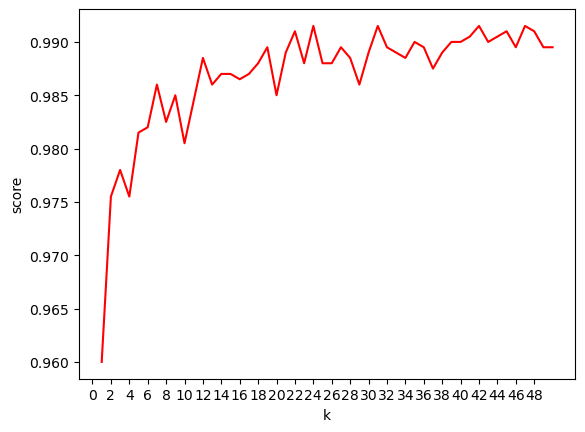

In [17]:
#对随机森林进行调参


rdftest = []
for i in range(50):
    rdfclf = ensemble.RandomForestClassifier(random_state=0,max_depth = i+1) 
    rdfclf = rdfclf.fit(X_train,Y_train) 
    rdfscore0 = accuracy_score(Y_test,rdfclf.predict(X_test))
    rdftest.append(rdfscore0)

plt.plot(range(1,51),rdftest,color='red')
plt.ylabel('score')
plt.xlabel('k')
plt.xticks(range(0,50,2))
plt.show()

#取4或者23可能比较合适，但考虑到这是在测试集上的准确率，我们选23

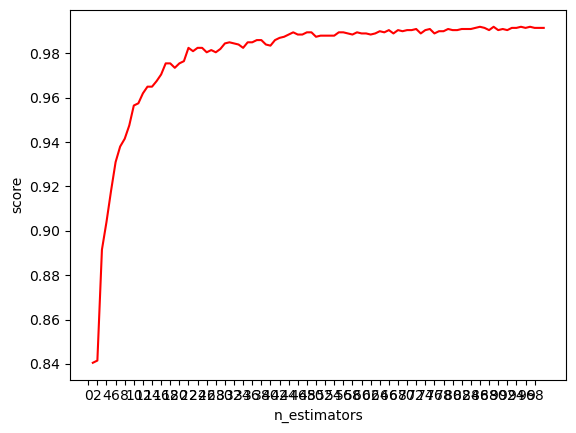

In [19]:
#对随机森林进行调参


rdftest = []
for i in range(100):
    rdfclf = ensemble.RandomForestClassifier(random_state=0,n_estimators = i+1, max_depth = 24) 
    rdfclf = rdfclf.fit(X_train,Y_train) 
    rdfscore0 = accuracy_score(Y_test,rdfclf.predict(X_test))
    rdftest.append(rdfscore0)

plt.plot(range(1,101),rdftest,color='red')
plt.ylabel('score')
plt.xlabel('n_estimators')
plt.xticks(range(0,100,2))
plt.show()

#取4或者23可能比较合适，但考虑到这是在测试集上的准确率，我们选23

In [27]:
#用循环达到多次试验的目的
from sklearn import ensemble
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

result = []

for i in range(1,4):
    
    result.append({})
    
    #对提取的文本进行向量化
    vectorize = CountVectorizer()
    X = vectorize.fit_transform(mixed_text['text'])
    
    #分割测试集与训练集
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    
    #逻辑回归
    lrclf = LogisticRegression(max_iter=500)
    lrclf.fit(X_train, Y_train)
    
    lraccuracy = accuracy_score(Y_test,lrclf.predict(X_test))
    lrprecision = precision_score(Y_test,lrclf.predict(X_test))
    lrrecall = recall_score(Y_test,lrclf.predict(X_test))
    lrrecall = f1_score(Y_test,lrclf.predict(X_test))
    
    result[i-1]['Logistic Regression'] = [lraccuracy,lrprecision,lrrecall,lrrecall]
    
    
    #随机森林
    rdfclf = ensemble.RandomForestClassifier(random_state=0, max_depth = 24) 
    rdfclf = rdfclf.fit(X_train,Y_train) 
    
    rdfaccuracy = accuracy_score(Y_test,rdfclf.predict(X_test))
    rdfprecision = precision_score(Y_test,rdfclf.predict(X_test))
    rdfrecall = recall_score(Y_test,rdfclf.predict(X_test))
    rdfrecall = f1_score(Y_test,rdfclf.predict(X_test))
    
    result[i-1]['Random Forest'] = [rdfaccuracy,rdfprecision,rdfrecall,rdfrecall]
    
    
    #SVM
    svmclf = svm.SVC(C=1,kernel='rbf',random_state = 0)
    svmclf.fit(X_train,Y_train)

    svmaccuracy = accuracy_score(Y_test,svmclf.predict(X_test))
    svmprecision = precision_score(Y_test,svmclf.predict(X_test))
    svmrecall = recall_score(Y_test,svmclf.predict(X_test))
    svmrecall = f1_score(Y_test,svmclf.predict(X_test))
    
    result[i-1]['SVM'] = [lraccuracy,lrprecision,lrrecall,lrrecall]
    
    #KNN
    knnclf = KNeighborsClassifier(n_neighbors=3, weights = 'distance') 
    knnclf = knnclf.fit(X_train,Y_train)
    
    knnaccuracy = accuracy_score(Y_test,knnclf.predict(X_test))
    knnprecision = precision_score(Y_test,knnclf.predict(X_test))
    knnrecall = recall_score(Y_test,knnclf.predict(X_test))
    knnrecall = f1_score(Y_test,knnclf.predict(X_test))
    
    result[i-1]['KNN'] = [knnaccuracy,knnprecision,knnrecall,knnrecall]
    
    print(i)

result

1
2
3


[{'Logistic Regression': [0.994,
   0.9930417495029821,
   0.9940298507462687,
   0.9940298507462687],
  'Random Forest': [0.9905,
   0.9920079920079921,
   0.9905236907730673,
   0.9905236907730673],
  'SVM': [0.994, 0.9930417495029821, 0.9940298507462687, 0.9940298507462687],
  'KNN': [0.6225, 0.5713467048710602, 0.7253546744270645, 0.7253546744270645]},
 {'Logistic Regression': [0.995,
   0.992849846782431,
   0.9948822927328557,
   0.9948822927328557],
  'Random Forest': [0.9915,
   0.9897750511247444,
   0.9912954429083461,
   0.9912954429083461],
  'SVM': [0.995, 0.992849846782431, 0.9948822927328557, 0.9948822927328557],
  'KNN': [0.615, 0.559489262913523, 0.714603409933284, 0.714603409933284]},
 {'Logistic Regression': [0.995,
   0.9938775510204082,
   0.9948927477017365,
   0.9948927477017365],
  'Random Forest': [0.9905,
   0.9897854954034729,
   0.9902912621359222,
   0.9902912621359222],
  'SVM': [0.995, 0.9938775510204082, 0.9948927477017365, 0.9948927477017365],
  'KNN': 

In [29]:
result1 = pd.DataFrame({'Model' : ['Logistic Regresstion','Random Forest','SVM','KNN'],
                        'Avg_Accuracy':[0.995,0.991,0.995,0.617],
                        'Avg_Precision':[0.994,0.991,0.993,0.563],
                        'Avg_Recall':[0.995,0.991,0.995,0.719],
                        'Avg_F1Score':[0.995,0.990,0.995,0.719]})

result1

,Model,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1Score
0,Logistic Regresstion,0.995,0.994,0.995,0.995
1,Random Forest,0.991,0.991,0.991,0.990
2,SVM,0.995,0.993,0.995,0.995
3,KNN,0.617,0.563,0.719,0.719
